## Phase I - Baseline Model Design and Review - HH

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib

2024-11-08 20:58:13.391128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 20:58:15.304048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 20:58:15.699822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 20:58:15.837835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 20:58:16.872155: I tensorflow/core/platform/cpu_feature_guar

#### Helper functions

In [2]:
## Resize and Printer Helper
def resize_show(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(300,300)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

#### Data Pull

In [3]:
# Specify the path to the zip file
# dataset_url = "https://dl.dropboxusercontent.com/scl/fi/hgz1prxm1kx14w5riy9du/ls_model_data_three.zip?rlkey=7cv22qxmmaeofr7jn6z7iayjy&dl=0?raw=1"
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/vmox93cwsx2vzrish3l63/land_ls_model_data_four.zip?rlkey=6uykz7bb0aoqbl8hgfkpt1t4f&dl=0?raw=1"

In [4]:
data_dir = tf.keras.utils.get_file('ls_model_data_four.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3200


In [6]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


In [7]:
land_class_num = len(folders)
land_class_num

2

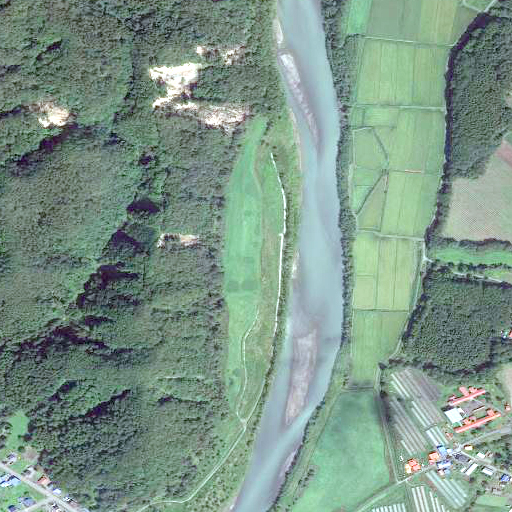

In [8]:
## Review an image
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[2]))

### Pull in Separate Test Dataset

In [9]:
# Specify the path to the zip file
# https://www.dropbox.com/scl/fi/wbi8iuftwvwnflvjr15pv/test_googleimages_land.zip?rlkey=h2stfvt9ocltsog29l26wo1ls&dl=0
# https://www.dropbox.com/scl/fi/w6fa6pd6hq7815p0jgkm2/test_google_images_landslides_two.zip?rlkey=zxiexqgti6b2nyemywc3itmhm&dl=0
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/w6fa6pd6hq7815p0jgkm2/test_google_images_landslides_two.zip?rlkey=zxiexqgti6b2nyemywc3itmhm&dl=0?raw=1"

In [10]:
data_dir_test = tf.keras.utils.get_file('test_google_images_landslides_two.zip', origin=test_dataset_url, extract=True)
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [11]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images


In [12]:
# Drill into each subdirectory and list files
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 44 .jpg images
  Subfolder: non-landslides
non-landslides: 49 .jpg images
  File: .DS_Store


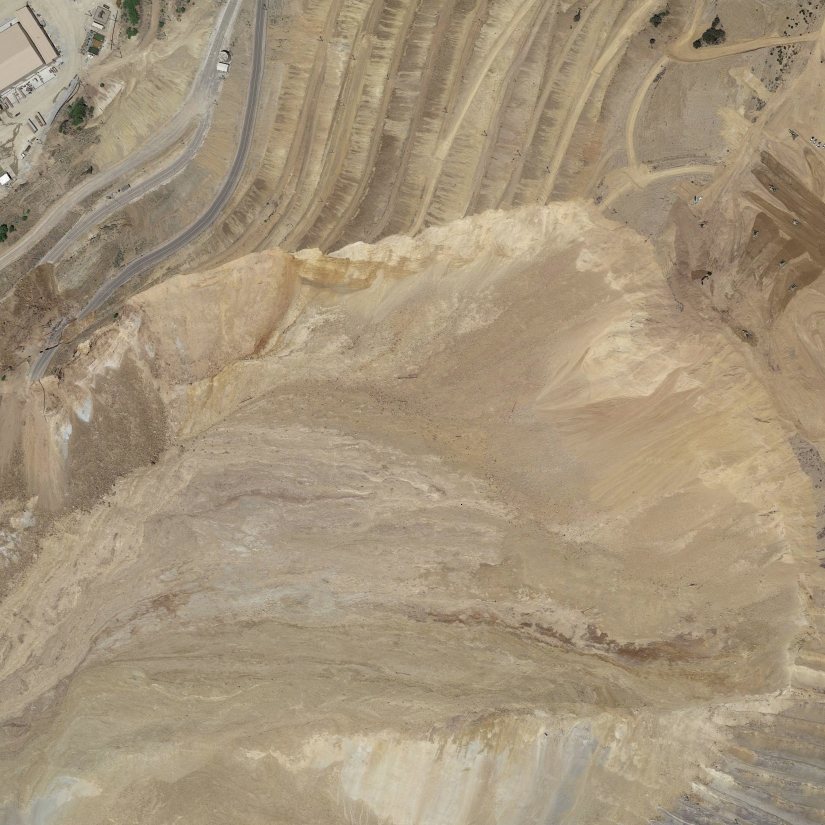

In [40]:
## Review an image
test_one = list(data_dir_test.glob('Google_Earth_Images/landslides/*'))
PIL.Image.open(str(test_one[2]))

2024-11-08 20:59:39.470612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43483 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e4:00.0, compute capability: 8.6


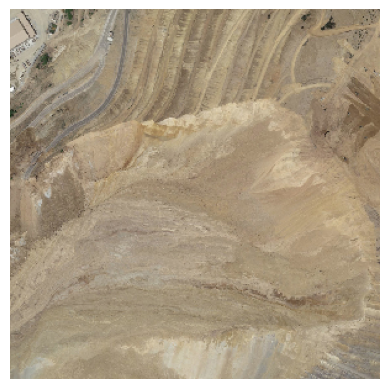

In [14]:
resize_show(test_one[2])

### Training: Setting up Data

In [15]:
## Set Batch, Image size and number of Classes. 
batch_size = 32
img_height = 300
img_width = 300

In [16]:
land_class_num

2

In [17]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.


In [18]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3200 files belonging to 2 classes.
Using 640 files for validation.


In [19]:
## Review class names based on dataset. 
class_names = train_dataset.class_names
print(class_names)

['landslide', 'non_landslide']


In [21]:
## Review sizes of images. 
counter_d = 0
for images, labels in train_dataset:
    if counter_d < 3:
        print(images.shape, labels.shape)
    counter_d += 1

(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)


2024-11-08 21:00:13.547899: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(2400).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

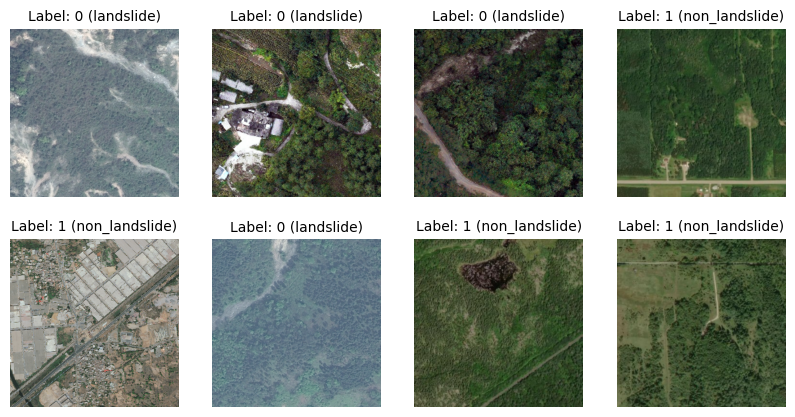

In [25]:
## Checking the Labels. 
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()


### Test Set

In [27]:
## Update path given the Google_Earth_Images/landslide vs. non-landslide directory structure. 
data_dir_test_lvltwo=pathlib.Path(data_dir_test) / 'Google_Earth_Images'
data_dir_test_lvltwo

PosixPath('/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images')

In [28]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test_lvltwo,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=512,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 93 files belonging to 2 classes.


In [31]:
## Review class names based on dataset. 
class_names = test_dataset.class_names
print(class_names)

['landslides', 'non-landslides']


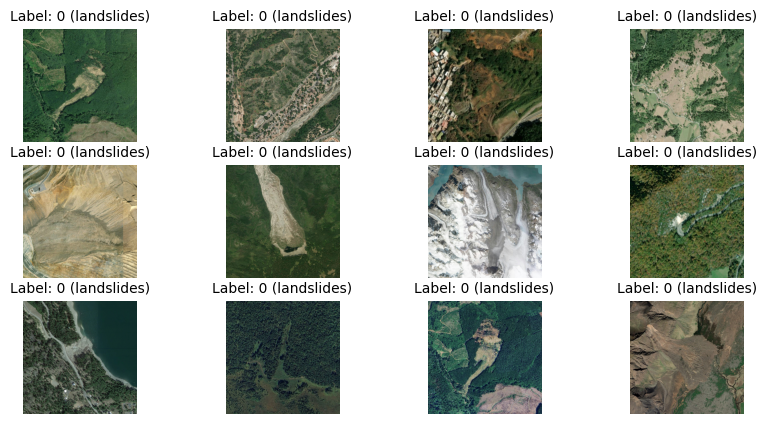

In [34]:
## Checking the Labels. 
plt.figure(figsize=(10, 5))
for images, labels in test_dataset.take(1):  # Take one batch
    for i in range(12):  # Display first 6 samples
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:10px solid gray">

**<span style="color:#0638b2; font-size:30px">
Model Design - Baseline
</span>** <br>

#### Plotting Helper

In [35]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

<hr style="border:1px solid gray">

### Design Model Baseline

In [36]:
ls_model_ph_one = Sequential([
  # data_augmentation,  ## Data Augmentation
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.2),  ## Dropout
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),  ## Dropout
    layers.Dense(2, activation='softmax')   ### Use with SparseCategoricalCrossentropy
    # layers.Dense(1, activation='sigmoid')   ### Use with BinaryCrossentropy
])

/home/waa4bq/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile**

In [37]:
## Setup model: Optmizer, Loss, Metrics
ls_model_ph_one.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001),
            loss='sparse_categorical_crossentropy',
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         # loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
ls_model_ph_one.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,803,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,814,354 (10.74 MB)

 Trainable params: 2,814,354 (10.74 MB)

 Non-trainable params: 0 (0.00 B)

#### **Fit**
ls_model_ph_one

In [39]:
## Fit Model
epochs = 10
landslide_history_one = ls_model_ph_one.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1731117932.101874  176000 service.cc:146] XLA service 0x7f41fc008200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731117932.101946  176000 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-11-08 21:05:32.579452: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-08 21:05:32.949846: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


13/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5094 - loss: 0.6949

I0000 00:00:1731117936.299679  176000 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5083 - loss: 0.6847 - val_accuracy: 0.5234 - val_loss: 0.6631
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5309 - loss: 0.6623 - val_accuracy: 0.5312 - val_loss: 0.6458
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5727 - loss: 0.6439 - val_accuracy: 0.8516 - val_loss: 0.6125
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7856 - loss: 0.6044 - val_accuracy: 0.8813 - val_loss: 0.5530
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8246 - loss: 0.5408 - val_accuracy: 0.8797 - val_loss: 0.4836
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8510 - loss: 0.4761 - val_accuracy: 0.8781 - val_loss: 0.4177
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8514 - loss: 0.4199 - val_accuracy: 0.8766 - val_loss: 0.3667
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8670 - loss: 0.3735 - val_accuracy: 0.8687 - val_loss: 0.

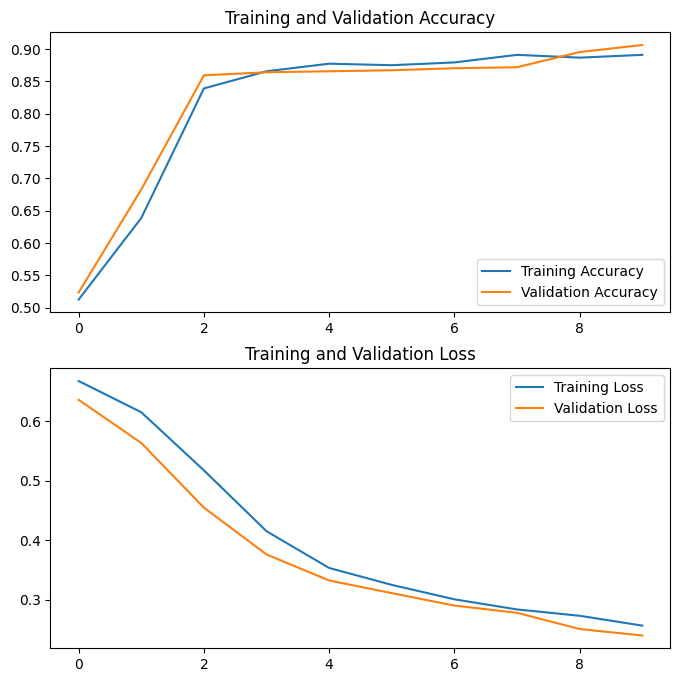

In [40]:
## Plot results
visualize_model_results(landslide_history_one)

#### **Testing**

In [54]:
print("Evaluate on test landslide images")
results = ls_model_ph_one.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 0.6209 - loss: 0.7088
test loss, test acc: [0.665706992149353, 0.6559139490127563]


In [55]:
# Get predictions and true labels
y_pred_probs = ls_model_ph_one.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


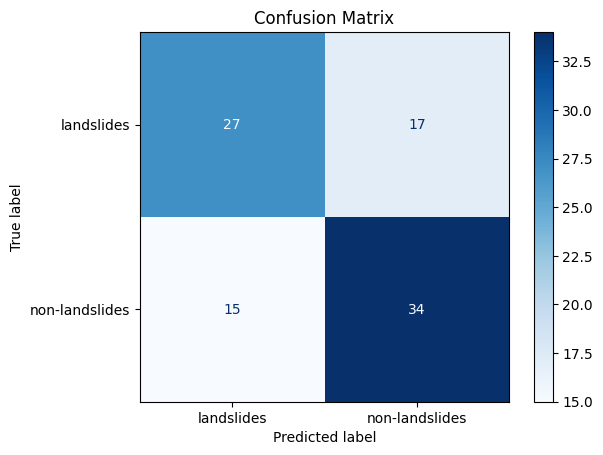

In [56]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Identify Image File to Prediction|True Labels

In [57]:
# Assuming you already have your test_dataset loaded
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Print a few file paths to confirm
print("Sample file paths:")
for file in file_paths[:10]:  # Preview first 5 paths
    print(file)

Sample file paths:
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_11454_large.jpg
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_14329_large.jpg
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_2787_medium.jpg
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_4346_large.jpg
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_4802_vylg.jpg
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_6038_vylg.jpg
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_8334_vylg.jpg
/home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth

In [58]:
# Get predictions
y_pred_probs = ls_model_ph_one.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Images with predicted and true labels:
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_11454_large.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_2787_medium.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_6038_vylg.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_Arc_9779_medium.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/landslides/NASA_GoogE_11239_cat.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/lands

<hr style="border:7px solid darkred">

**<span style="color:#0638b2; font-size:30px">
Model Design w/ Transfer Learning
</span>** <br>


Pre-Training with EfficientNet
- Strengths: EfficientNet models scale well in terms of parameters and efficiency, balancing accuracy with computational cost, which is especially useful for large datasets.
- Suitability: EfficientNet performs exceptionally well on high-resolution images, which is ideal for detecting fine details in satellite images.
- https://viso.ai/deep-learning/efficientnet/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

**Setting up EfficientNet**
- Note - using B3 as this is set up for 300x300 images. 

In [59]:
## Import
from tensorflow.keras.applications import EfficientNetB3

In [60]:
# Setting up parameters for model. 
IMG_SIZE=300
learn_rate_land = .001  ## For optimizer.
print(land_class_num) ## Check class number AND use as argument below.

2


**Helper Functions**

Saturation
- The saturation factor is sampled randomly from a uniform distribution in the range [lower, upper].
- A saturation factor of 1.0 means no change in saturation.
- A saturation factor below 1.0 decreases the saturation (the image will appear less vibrant or more grayscale).
- A saturation factor above 1.0 increases the saturation (the image will appear more vibrant).

In [61]:
## Helper Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(factor=0.4),
    # layers.RandomSaturation(.7, seed=516) ## Error
    layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.1, upper=1))
  ]
)

In [62]:
# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


## Review model design. 
landslide_model_ENB3.summary()

In [63]:
landslide_model_ENB3 = build_model(num_classes=land_class_num)

epochs = 20  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.8000 - loss: 0.4880 - val_accuracy: 0.9641 - val_loss: 0.1788
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9599 - loss: 0.1122 - val_accuracy: 0.9781 - val_loss: 0.0954
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9723 - loss: 0.0748 - val_accuracy: 0.9875 - val_loss: 0.0536
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9829 - loss: 0.0585 - val_accuracy: 0.9891 - val_loss: 0.0379
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9766 - loss: 0.0594 - val_accuracy: 0.9875 - val_loss: 0.0287
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9896 - loss: 0.0307 - val_accuracy: 0.9922 - val_loss: 0.0243
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9883 - loss: 0.0359 - val_accuracy: 0.9891 - val_loss: 0.0217
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9915 - loss: 0.0258 - val_accuracy: 0.9906 - 

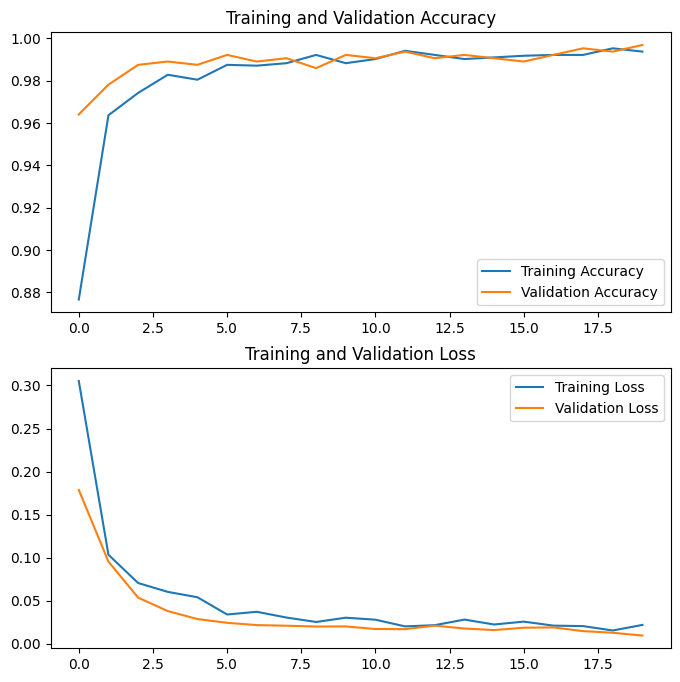

In [64]:
## Plot results
visualize_model_results(landslide_ENB3_hist)

#### **Testing**

In [65]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6205 - loss: 1.5720 
test loss, test acc: [1.2611594200134277, 0.7096773982048035]


In [66]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

1/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f363b78a290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


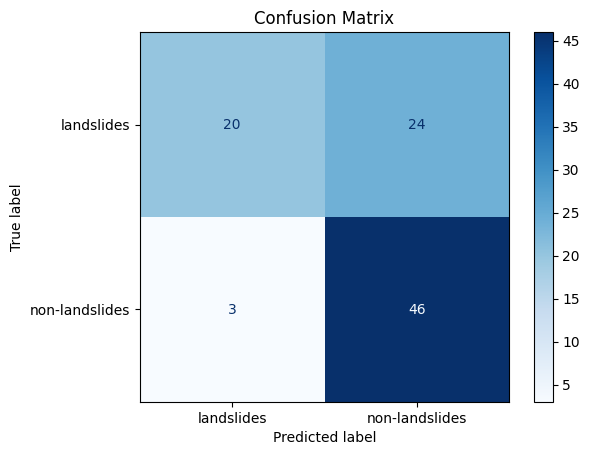

In [67]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [68]:
# file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample
# # Get predictions
# y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 1:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")



Images with predicted and true labels:
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/non-landslides/nasa_g_2000m_10521_2017_large_nonL_three.jpg, Predicted: 0, True Label: 1
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/non-landslides/nasa_g_2000m_10521_2017_large_nonL_two.jpg, Predicted: 0, True Label: 1
File: /home/waa4bq/.keras/datasets/test_google_images_landslides_two_extracted/Google_Earth_Images/non-landslides/nasa_g_2400m_9734_2020_vylg_nonL_fourteen.jpg, Predicted: 0, True Label: 1


<hr style="border:2px solid gray">

## Testing a single image.

#### Helper Functions

In [69]:
## Prediction Helper
def predict_landslide_image(image_path, model):
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width) )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    # score = tf.nn.softmax(predictions[0])
    score = predictions[0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

---

### Image One

In [70]:
## Load Image
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/viovy9pcma2y6hq58ntns/NASA_GoogE_14445.jpg?rlkey=ltitymrzuarrxxogge32c1kbi&dl=0?raw=1"
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_14445', origin=landslide_img_one_url)

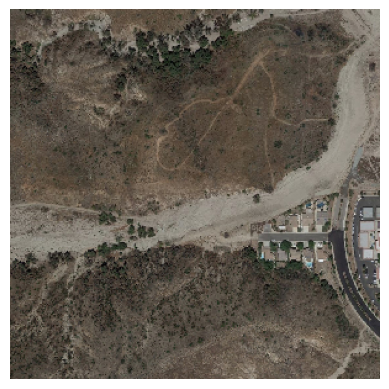

In [71]:
resize_show(landslide_img_one_path)

#### **Prediction**

In [72]:
predict_landslide_image(landslide_img_one_path, landslide_model_ENB3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
This image most likely belongs to non-landslides with a 97.53 percent confidence.


### Image Two

In [73]:
landslide_img_two_url = "https://dl.dropboxusercontent.com/scl/fi/7x41si7aih0bjh1py2phy/NASA_GoogE_14445_NonSlide.jpg?rlkey=3ll97pdrjwr9b10rcvineeynm&dl=0?raw=1"
landslide_img_two_path = tf.keras.utils.get_file('NASA_GoogE_14445_NonSlide', origin=landslide_img_two_url)

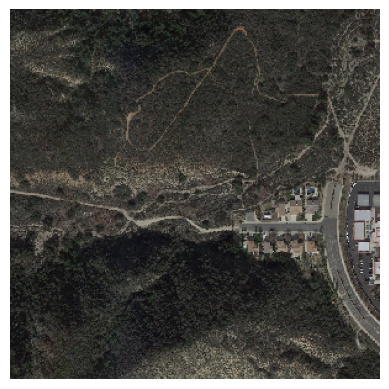

In [74]:
resize_show(landslide_img_two_path)

#### **Prediction**

In [75]:
predict_landslide_image(landslide_img_two_path, landslide_model_ENB3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to non-landslides with a 99.99 percent confidence.
